In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import re
import os
import random
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())
print(os.getcwd())

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import catboost
from catboost import CatBoostRegressor

import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance as xgb_plot_importance

import lightgbm
from lightgbm import LGBMRegressor
from lightgbm import plot_importance as lgbm_plot_importance

print(f'CatBoost Version : {catboost.__version__}')
print(f'XGBoost Version  : {xgboost.__version__}')
print(f'LightGBM Version : {lightgbm.__version__}')

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

True 1
/data/ephemeral/home/level1-bookratingprediction-recsys-06
CatBoost Version : 1.2.2
XGBoost Version  : 2.0.2
LightGBM Version : 4.1.0


![data](./code/data/Data_Schema.png)

In [158]:
books = pd.read_csv('/home/code/data/books.csv')
users = pd.read_csv('/home/code/data/users.csv')
rating_train = pd.read_csv('/home/code/data/train_ratings.csv')
rating_test = pd.read_csv('/home/code/data/test_ratings.csv')
print(books.shape, users.shape, rating_train.shape, rating_test.shape)

(149570, 10) (68092, 3) (306795, 3) (76699, 3)


## `books`

In [159]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [160]:
def text_preprocessing(summary):
    """
    Parameters
    ----------
    summary : pd.Series
        정규화와 같은 기본적인 전처리를 하기위한 텍스트 데이터를 입력합니다.
    ----------
    """
    summary = re.sub("[.,\'\"''""!?]", "", summary)
    summary = re.sub("[^0-9a-zA-Z\\s]", " ", summary)
    summary = re.sub("\s+", " ", summary)
    summary = summary.lower()
    return summary


### `isbn`
- https://sciencing.com/difference-isbn-13-isbn-10-5890031.html
- group identifier / publisher identifier / title identifier / and check digit로 구성
- Format : X-XXX-XXXXX-X

> **ISBN 확인**
- URL 정보를 사용해서 ISBN이 재대로 입력됐는지 확인

In [161]:
books['img_url_isbn'] = books['img_url'].apply(lambda x : x.split('/')[5].split('.')[0])
books[books['isbn'] != books['img_url_isbn']]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,img_url_isbn


In [162]:
books.drop(columns = 'img_url_isbn', inplace = True)

### `book_author` 결측치 확인
- 실제 저자가 없는 책
- 동일한 `book_title`의 데이터도 없음
- => 동일한 `publisher`의 최빈값으로 대체

In [163]:
books[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,NaN,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg


In [164]:
books.loc[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0], 'book_author'] = \
    books.loc[books['publisher'] == books.loc[books['book_author'].isna(), 'publisher'].values[0], 'book_author'].mode().values[0]
print(books['book_author'].isna().sum())

0


In [165]:
# 텍스트 전처리 진행
books["book_title"] = books["book_title"].apply(lambda x : text_preprocessing(x))
books["book_author"] = books["book_author"].apply(lambda x : text_preprocessing(x))
books["publisher"] = books["publisher"].apply(lambda x : text_preprocessing(x))

### `year_of_publication`
- 10년 단위로 범주화

In [166]:
# 1970과 1980을 합침
def preprocess_year(x) :
    if x < 1980 :
        return 1980
    elif (x >= 1980) and (x < 1990) :
        return 1990
    elif (x >= 1990) and (x < 2000) :
        return 2000
    else :
        return 2010
    
books['years'] = books['year_of_publication'].apply(preprocess_year)
books['years'].value_counts()

years
2000    72358
2010    46301
1990    23809
1980     7102
Name: count, dtype: int64

### `publisher`
- `isbn`의 앞 4개의 숫자를 활용하여 `new_publisher` 생성

In [167]:
publisher_dict = (books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()), columns = ['publisher', 'count'])

publisher_count_df = publisher_count_df.sort_values(by = ['count'], ascending = False)
display(publisher_count_df.head(), books['publisher'].nunique())

,publisher,count
0,harlequin,3006
1,ballantine books,2322
2,pocket,2274
3,penguin books,1943
4,bantam books,1938


11189

In [168]:
modify_list = publisher_count_df[publisher_count_df['count'] > 1]['publisher'].values

for publisher in tqdm.tqdm(modify_list) :
    try :
        number = books[books['publisher'] == publisher]['isbn'].apply(lambda x : x[2:6]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x : x[2:6]) == number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x : x[2:6]) == number].index, 'new_publisher'] = right_publisher
    except :
        pass
books['new_publisher'] = books['new_publisher']
print(books['new_publisher'].nunique())

100%|██████████| 5179/5179 [08:24<00:00, 10.26it/s]

2264


In [170]:
books['new_publisher'].value_counts()

new_publisher
nan                           42833
pocket                         4238
ballantine books               2455
penguin books                  2403
harlequin                      2263
                              ...  
bahai distribution service        1
teubner verlag                    1
northstone publishing             1
overlook connection press         1
ics books                         1
Name: count, Length: 2264, dtype: int64

### `language`, `category`, `summary`
- `language` & `category` & `summary`가 모두 결측인 행 -> 67227행
- `language` & `summary`만 결측인 행 -> 67227 + 1624행

In [171]:
display(books.loc[books['language'].isna(), ['language', 'category', 'summary']])
display(books.loc[books['language'].isna() & books['category'].notnull()])
display(books.loc[books['language'].isna() & books['summary'].notnull()])

,language,category,summary
5,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN
10,NaN,NaN,NaN
11,NaN,NaN,NaN
...,...,...,...
149560,NaN,NaN,NaN
149561,NaN,NaN,NaN
149564,NaN,NaN,NaN
149567,NaN,NaN,NaN


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years,new_publisher


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years,new_publisher


- `language`는 `isbn`의 region 정보를 활용하여 결측치 대체

In [172]:
region_code = set([code[:2] for code in books['isbn']])

for code in region_code :
    lang = books.loc[books['isbn'].str.startswith(str(code)), 'language']
    mode = lang.mode().iloc[0] if not lang.mode().empty else "en"
    if len(mode) != 2:
        books.loc[(books['isbn'].str.startswith(str(code))), 'language'] = "en"
    #print(mode)
    books.loc[(books['isbn'].str.startswith(str(code))) & (books['language'].isna()), 'language'] = mode

books['language'].isna().sum()

0

In [173]:
books.language.value_counts()


language
en       135034
de         6540
es         3724
fr         3302
it          478
pt          195
nl          192
da           37
ca           23
ms           10
no            9
ja            6
ru            3
la            3
gl            3
ro            1
th            1
el            1
fa            1
eo            1
gd            1
ga            1
vi            1
zh-CN         1
zh-TW         1
ko            1
Name: count, dtype: int64

### `category`
- 상위 카테고리인 `category_high`를 생성

In [174]:
# 대괄호 삭제
books['category'] = books['category'].apply(lambda x : re.sub('[\W_]+',  ' ', str(x).lower()).strip())

category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
category_df.head()

,category,count
0,nan,68851
1,fiction,33016
2,juvenile fiction,5835
3,biography autobiography,3326
4,history,1927


In [175]:
books['category_high'] = books['category'].copy()

categories = ['garden', 'crafts', 'physics', 'adventure', 'music', 'fiction', 'nonfiction', 'science', 'science fiction', 'social', 'homicide', 
              'sociology', 'disease', 'religion', 'christian', 'philosophy', 'psycholog', 'mathemat', 'agricult', 'environmental',
              'business', 'poetry', 'drama', 'literary', 'travel', 'motion picture', 'children', 'cook', 'literature', 'electronic', 
              'humor', 'animal', 'bird', 'photograph', 'computer', 'house', 'ecology', 'family', 'architect', 'camp', 'criminal', 'language', 'india']

for category in categories :
    books.loc[books[books['category'].str.contains(category, na = False)].index, 'category_high'] = category
books['category'] = books['category']

In [176]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category', 'count']
category_high_df.head(10)

,category,count
0,nan,68851
1,fiction,39678
2,biography autobiography,3326
3,history,1927
4,religion,1824
5,nonfiction,1427
6,humor,1291
7,social,1271
8,business,1146
9,cook,1125


In [177]:
# 5개 이하인 항목은 others
others_list = category_high_df[category_high_df['count'] < 5]['category'].values
print(len(others_list))

books.loc[books[books['category_high'].isin(others_list)].index, 'category_high'] = 'others'

2856


In [178]:
books['category_high'] = books['category_high'].replace('nan', np.nan)
books['category_high'] = books['category_high'].replace('unknown', np.nan)
print(books['category_high'].isna().sum())

books['category_high'] = books['category_high'].fillna('fiction')

68851


In [179]:
book_df = books.copy()

In [180]:
books.to_csv('/home/code/data/books_preprocessed.csv', index = False)

In [182]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        149570 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB


In [181]:
ac = pd.read_csv("/home/code/data/books_preprocessed.csv")
ac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        106737 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB


## `users`

In [51]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


### `city`, `state`, `country` 전처리 방법 1 (성능 best)

In [183]:
users['location'] = users['location'].str.replace(r'[^a-zA-Z:,]', '', regex = True)

users['city'] = users['location'].apply(lambda x : x.split(',')[0].strip())
users['state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('n/a', np.nan)
users = users.replace('', np.nan)

users[['location', 'city', 'state', 'country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  68092 non-null  object
 1   city      67963 non-null  object
 2   state     64838 non-null  object
 3   country   65968 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [184]:
# preprocess_loc.csv 전처리 방법
modify_location = users[(users['country'].isna())&(users['city'].notnull())]['city'].values
location = users[(users['location'].str.contains('seattle'))&(users['country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in tqdm.tqdm(modify_location):
    try:
        right_location = users[(users['location'].str.contains(location))&(users['country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in tqdm.tqdm(location_list) :
    users.loc[users[users['city'] == location.split(',')[0]].index, 'state'] = location.split(',')[1]
    users.loc[users[users['city'] == location.split(',')[0]].index, 'country'] = location.split(',')[2]

city2idx = {v:k for k,v in enumerate(users['city'].unique())}
state2idx = {v:k for k,v in enumerate(users['state'].unique())}
country2idx = {v:k for k,v in enumerate(users['country'].unique())}

users['city'] = users['city'].map(city2idx)
users['state'] = users['state'].map(state2idx)
users['country'] = users['country'].map(country2idx)

  0%|          | 0/2113 [00:00<?, ?it/s]

100%|██████████| 1963/1963 [00:21<00:00, 92.71it/s]


### `city`, `state`, `country` 전처리 방법 2 (성능이 더 안좋은 듯)
- `city`가 가장 결측치가 적지만, 고윳값이 많아서 모델링할 때 그닥 좋은 성능을 낼 것 같지 않아보임
    - `country`의 결측치를 채워서 분석에 사용하는 쪽으로 방향을 설정

In [190]:
# 11959 1319 269
print(users['city'].nunique(), users['state'].nunique(), users['country'].nunique())

11959 1319 269


In [186]:
# country가 결측 / city 결측 X인 경우
cities = users[(users['city'].notnull()) & (users['country'].isna())]['city'].values

for city in tqdm.tqdm(cities) :
    try :
        country = users.loc[(users['location'].str.contains(city)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(city)) & (users['country'].isna()), 'country'] = country
    except :
        pass
    
# country가 결측 / state 결측 X인 경우
states = users[(users['state'].notnull()) & (users['country'].isna())]['state'].values

for state in tqdm.tqdm(states) :
    try :
        country = users.loc[(users['location'].str.contains(state)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(state)) & (users['country'].isna()), 'country'] = country
    except :
        pass

# 각 나라 별로 location의 최빈값으로 대체
countries_list = users['country'].value_counts()
for country in tqdm.tqdm(countries_list.index) :
    try :
        new_country = users.loc[(users['location'].str.contains(country)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(country)) & (users['country'] == country), 
                  'country'] = new_country
    except :
        pass

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 269/269 [00:00<00:00, 84896.00it/s]


In [187]:
print(users['country'].unique())

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

- `country`의 오타나 오기입되어 있는 값 처리
- canada -> 'canada', 'cananda', 'vvh', 'lkjlj'
- italy -> 'italia', 'italy', 'litalia', 'ineurope'
- phillipines -> 'phillipines', 'phillippines'
- spain -> 'catalunyaspain', 'spain'
- unitedkingdom -> 'unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'
- usa -> 'unitedstates', 'unitedstaes', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'
- uruguay -> 'urugua', 'uruguay'

In [188]:
print(f'Before : {users["country"].nunique()}')
country_mapping = {
    'canada': ['canada', 'cananda', 'vvh', 'lkjlj'],
    'italy': ['italia', 'italy', 'litalia', 'ineurope'],
    'phillipines': ['phillipines', 'phillippines'],
    'spain': ['catalunyaspain', 'spain'],
    'unitedkingdom': ['unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'],
    'usa': ['unitedstates', 'unitedstaes', 'unitedsates', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'],
    'uruguay': ['urugua', 'uruguay']
}

for target_country, aliases in country_mapping.items() :
    users['country'].replace(aliases, target_country, inplace = True)

print(f'After : {users["country"].nunique()}')

Before : 269
After : 269


In [189]:
print(users['country'].isna().sum())
users['country'].value_counts().to_frame()
# 여기까지함

0


,count
country,
2,45206
0,6525
9,3604
6,3148
11,1816
...,...
221,1
222,1
223,1


In [191]:
# 10개 이하의 country를 others로 변환
others = users['country'].value_counts()[users['country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['country'] == country), 'country'] = 'others'
    except :
        pass

100%|██████████| 215/215 [00:00<00:00, 221.75it/s]


In [192]:
# 나머지 결측치에 대해서도 others로 변환
users['country'] = users['country'].fillna('others')
users['state'] = users['state'].fillna('others')
users['city'] = users['city'].fillna('others')
print(users['country'].nunique())


55


In [72]:
# 텍스트 전처리 진행
'''
users["country"] = users["country"].astype(str).apply(lambda x : text_preprocessing(x))
users["state"] = users["state"].astype(str).apply(lambda x : text_preprocessing(x))
users["city"] = users["city"].astype(str).apply(lambda x : text_preprocessing(x))
'''

In [193]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
 3   city      68092 non-null  int64  
 4   state     68092 non-null  int64  
 5   country   68092 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 3.1+ MB


### `age`
- 국가별 `age`의 중앙값으로 대체
- 국가별 `age`의 중앙값이 존재하지 않는 경우, 전체 `age`의 중앙값으로 대체

In [194]:
country_age_median = users.groupby('country')['age'].median()
users['age'] = users.apply(lambda x : country_age_median[x['country']] if pd.isna(x['age']) else x['age'], axis = 1)

global_age_median = users['age'].median()
users['age'].fillna(global_age_median, inplace = True)
print(users['age'].isna().sum())

0


- 10살 단위 연령대로 분할하여 `new_age` 변수 생성

In [197]:
labels = ['3-6','6-8','8-12','12-15','15-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
bins = [3, 6, 8, 12, 15, 18, 25, 34, 44, 54, 64, 74, 100]
    
users['age'] = users['age'].apply(lambda x: 100 if x>100 else x)
users.loc[(users['age'] > 90), 'age'] = np.nan

users['age'] = users['age'].fillna(users['age'].mean())
users['age'] = users['age'].astype(np.int64)

users['new_age'] = pd.cut(users.age, bins, labels = labels,include_lowest = True)

In [198]:
users['new_age'].value_counts()

new_age
35-44    29069
25-34    18124
18-25     6959
45-54     5946
55-64     3399
15-18     2012
65-74     1109
12-15     1086
75+        197
8-12       143
6-8         34
3-6         14
Name: count, dtype: int64

In [77]:
'''
users['new_age'] = ((users['age'] // 10) * 10).astype(int)
users[['age', 'new_age']]
'''

,age,new_age
0,33.0,30
1,49.0,40
2,34.0,30
3,30.0,30
4,36.0,30
...,...,...
68087,54.0,50
68088,74.0,70
68089,36.0,30
68090,33.0,30


### `user_lang`
- 유저의 언어를 국가로 예측

- 'en': English (영어)
- 'de': German (독일어)
- 'fr': French (프랑스어)
- 'es': Spanish (스페인어)
- 'ca': Catalan (카탈로니아어)
- 'it': Italian (이탈리아어)
- 'da': Danish (덴마크어)
- 'nl': Dutch (네덜란드어)
- 'pt': Portuguese (포르투갈어)
- 'ro': Romanian (루마니아어)
- 'no': Norwegian (노르웨이어)
- 'ms': Malay (말레이어)
- 'la': Latin (라틴어)
- 'ru': Russian (러시아어)
- 'el': Greek (그리스어)
- 'zh-CN': Chinese (Simplified) (중국어 간체)
- 'th': Thai (태국어)
- 'gl': Galician (갈리시아어)
- 'ja': Japanese (일본어)
- 'fa': Persian (페르시아어)
- 'eo': Esperanto (에스페란토)
- 'gd': Scottish Gaelic (스코틀랜드 게일어)
- 'ga': Irish (아일랜드어)
- 'vi': Vietnamese (베트남어)
- 'zh-TW': Chinese (Traditional) (중국어 번체)
- 'ko': Korean (한국어)

In [ ]:
'''
country2lang = {'en': ['unitedkingdom','uk','arizona', 'illinois','belize','poland', 'antiguaandbarbuda','arkansas', 'aroostook', 'australiancapitalterritory', 'barbados','alaska','vanwert','auckland','unitedstate','america',  'australia','us', 'usa','california', 'texas',  'wisconsin', 'victoria','virginia', 'wales',  'scotland','washington', 'southdakota', 'slovakia', 'queensland', 'saintlucia', 'phillipines', 'philippines',],
                'de': ['berlin','austria',],
                'fr': [ 'quebec',],
                'es': ['spain', 'puertorico', 'pontevedra', 'austin', 'argentina', 'andalucia', 'honduras',],
                'ca': [ 'andorra',],
                'it': [],
                'da': [],
                'nl': ['belgium','aruba',],
                'pt': ['portugal','angola',],
                'ro': [],
                'no': [],
                'ms': [],
                'la': [],
                'ru': [ 'russia', 'ukraine',],
                'el': [ 'greece',],
                'zh-CN': [],
                'th': ['thailand',],
                'gl': [],
                'ja': [],
                'fa': [],
                'eo': [],
                'gd': [],
                'ga': [],
                'vi': [ 'vietnam',],
                'zh-TW': [],
                'ko' : ['southkorea', 'seoul',]}
'''

In [199]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   user_id   68092 non-null  int64   
 1   location  68092 non-null  object  
 2   age       68092 non-null  int64   
 3   city      68092 non-null  int64   
 4   state     68092 non-null  int64   
 5   country   68092 non-null  object  
 6   new_age   68092 non-null  category
dtypes: category(1), int64(4), object(2)
memory usage: 3.2+ MB


In [200]:
users.to_csv('/home/code/data/users_preprocessed.csv', index = False)

## `ratings`와 Merge

In [201]:
path = '/home/code/data/'
books_pre = books.copy()
# books_pre = pd.read_csv(path + 'books_preprocessed.csv')
users_pre = pd.read_csv(path + 'users_preprocessed.csv')
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

print(books_pre.shape, users_pre.shape, train_ratings.shape, test_ratings.shape)

(149570, 13) (68092, 7) (306795, 3) (76699, 3)


In [202]:
display(books_pre.info(), users_pre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        149570 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entr

None

None

In [203]:
books_final = books_pre[['isbn', 'book_title', 'book_author', 'language', 'years', 'new_publisher', 'category_high']]
users_final = users_pre[['user_id', 'city', 'state', 'country', 'new_age']] # [['user_id', 'country', 'new_age']]

In [204]:
train_ratings['index'] = train_ratings.index
train_df = pd.merge(books_final, train_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
train_df = pd.merge(users_final, train_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
train_df = train_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        306795 non-null  int64  
 1   city           306795 non-null  int64  
 2   state          306795 non-null  int64  
 3   country        306795 non-null  object 
 4   new_age        306795 non-null  object 
 5   isbn           306795 non-null  object 
 6   book_title     306795 non-null  object 
 7   book_author    306795 non-null  object 
 8   language       306795 non-null  object 
 9   years          306795 non-null  float64
 10  new_publisher  306795 non-null  object 
 11  category_high  306795 non-null  object 
 12  rating         306795 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 30.4+ MB


In [205]:
# 유저별 리뷰 횟수 추가
user_id_counts = train_df['user_id'].value_counts()
train_df['review_counts'] = train_df['user_id'].map(user_id_counts)

In [206]:
'''
# 유저별 가장 많이 고른 카테고리 추가
top_category_by_user = train_df.groupby('user_id')['category_high'].apply(lambda x: x.value_counts().idxmax())
train_df['top_category'] = train_df['user_id'].map(top_category_by_user)
'''

In [207]:
'''
# 책의 평균 평첨 추가
average_rating_by_isbn = train_df.groupby('isbn')['rating'].mean().reset_index()
train_df = pd.merge(train_df, average_rating_by_isbn, on='isbn', how='left', suffixes=('', '_book_avg'))
'''

In [208]:
train_df.head()

,user_id,city,state,country,new_age,isbn,book_title,book_author,language,years,new_publisher,category_high,rating,review_counts,top_category,rating_book_avg
0,8,0,0,0,25-34,0002005018,clara callan,richard bruce wright,en,2010.0,harperflamingo canada,actresses,4.0,7,fiction,6.857143
1,67544,3,0,0,25-34,0002005018,clara callan,richard bruce wright,en,2010.0,harperflamingo canada,actresses,7.0,7,fiction,6.857143
2,123629,5,0,0,25-34,0002005018,clara callan,richard bruce wright,en,2010.0,harperflamingo canada,actresses,8.0,1,actresses,6.857143
3,200273,6,0,0,25-34,0002005018,clara callan,richard bruce wright,en,2010.0,harperflamingo canada,actresses,8.0,1,actresses,6.857143
4,210926,7,0,0,25-34,0002005018,clara callan,richard bruce wright,en,2010.0,harperflamingo canada,actresses,9.0,5,fiction,6.857143


In [209]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          306795 non-null  int64  
 1   city             306795 non-null  int64  
 2   state            306795 non-null  int64  
 3   country          306795 non-null  object 
 4   new_age          306795 non-null  object 
 5   isbn             306795 non-null  object 
 6   book_title       306795 non-null  object 
 7   book_author      306795 non-null  object 
 8   language         306795 non-null  object 
 9   years            306795 non-null  float64
 10  new_publisher    306795 non-null  object 
 11  category_high    306795 non-null  object 
 12  rating           306795 non-null  float64
 13  review_counts    306795 non-null  int64  
 14  top_category     306795 non-null  object 
 15  rating_book_avg  306795 non-null  float64
dtypes: float64(3), int64(4), object(9)
mem

In [216]:
test_ratings['index'] = test_ratings.index
test_df = pd.merge(books_final, test_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
test_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = test_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        76699 non-null  int64  
 1   city           76699 non-null  int64  
 2   state          76699 non-null  int64  
 3   country        76699 non-null  object 
 4   new_age        76699 non-null  object 
 5   isbn           76699 non-null  object 
 6   book_title     76699 non-null  object 
 7   book_author    76699 non-null  object 
 8   language       76699 non-null  object 
 9   years          76699 non-null  float64
 10  new_publisher  76699 non-null  object 
 11  category_high  76699 non-null  object 
 12  rating         76699 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 7.6+ MB


In [217]:
test_df['review_counts'] = test_df['user_id'].map(user_id_counts)
test_df["review_counts"] = test_df["review_counts"].fillna(0)

In [218]:
'''
# 유저별 가장 많이 고른 카테고리 추가
test_df['top_category'] = test_df['user_id'].map(top_category_by_user)
test_df["top_category"] = test_df["top_category"].fillna("new")

# 책의 평균 평점
test_df = pd.merge(test_df, average_rating_by_isbn, on='isbn', how='left', suffixes=('', '_book_avg'))
test_df["rating_book_avg"] = test_df["rating_book_avg"].fillna(-1)

'''

In [220]:
test_df.head()

,user_id,city,state,country,new_age,isbn,book_title,book_author,language,years,new_publisher,category_high,rating,review_counts,top_category,rating_book_avg
0,11676,2,1,1,35-44,0002005018,clara callan,richard bruce wright,en,2010.0,harperflamingo canada,actresses,0.0,5520.0,fiction,6.857143
1,116866,1,0,0,25-34,0002005018,clara callan,richard bruce wright,en,2010.0,harperflamingo canada,actresses,0.0,49.0,fiction,6.857143
2,152827,1,0,0,35-44,0060973129,decision in normandy,carlo deste,en,2000.0,perennial,others,0.0,5.0,fiction,8.000000
3,157969,15,10,2,25-34,0374157065,flu the story of the great influenza pandemic ...,gina bari kolata,en,2000.0,nan,medical,0.0,2.0,biography autobiography,7.600000
4,67958,25,18,2,35-44,0399135782,the kitchen gods wife,amy tan,en,2000.0,putnam pub group,fiction,0.0,11.0,fiction,7.571429


In [221]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          76699 non-null  int64  
 1   city             76699 non-null  int64  
 2   state            76699 non-null  int64  
 3   country          76699 non-null  object 
 4   new_age          76699 non-null  object 
 5   isbn             76699 non-null  object 
 6   book_title       76699 non-null  object 
 7   book_author      76699 non-null  object 
 8   language         76699 non-null  object 
 9   years            76699 non-null  float64
 10  new_publisher    76699 non-null  object 
 11  category_high    76699 non-null  object 
 12  rating           76699 non-null  float64
 13  review_counts    76699 non-null  float64
 14  top_category     76699 non-null  object 
 15  rating_book_avg  76699 non-null  float64
dtypes: float64(4), int64(3), object(9)
memory usage: 9.4+ MB


- `avg_rating`
    - `user_id`별 평균 `rating`의 값을 계산

In [222]:
'''
rating_avg = train_df.groupby('user_id', as_index = False)['rating'].mean().rename({'rating' : 'rating_avg'}, axis = 1)
train_df = pd.merge(train_df, rating_avg, how = 'left', on = 'user_id')
test_df = pd.merge(test_df, rating_avg, how = 'left', on = 'user_id')
test_df['rating_avg'].fillna(train_df['rating'].mean(), inplace = True)
'''

In [223]:
train_df['user_id'] = train_df['user_id'].astype('str')
train_df['city'] = train_df['city'].astype('str')
train_df['state'] = train_df['state'].astype('str')
train_df['country'] = train_df['country'].astype('str')
train_df['new_age'] = train_df['new_age'].astype('str')
train_df['years'] = train_df['years'].astype('int').astype('str')
train_df['rating'] = train_df['rating'].astype('int')
train_df['review_counts'] = train_df['review_counts'].astype('int')
#train_df['top_category'] = train_df['top_category'].astype('str')

test_df['user_id'] = test_df['user_id'].astype('str')
test_df['city'] = test_df['city'].astype('str')
test_df['state'] = test_df['state'].astype('str')
test_df['country'] = test_df['country'].astype('str')
test_df['new_age'] = test_df['new_age'].astype('str')
test_df['years'] = test_df['years'].astype('int').astype('str')
test_df['rating'] = test_df['rating'].astype('int')
test_df['review_counts'] = test_df['review_counts'].astype('int')
#test_df['top_category'] = test_df['top_category'].astype('str')

In [224]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          306795 non-null  object 
 1   city             306795 non-null  object 
 2   state            306795 non-null  object 
 3   country          306795 non-null  object 
 4   new_age          306795 non-null  object 
 5   isbn             306795 non-null  object 
 6   book_title       306795 non-null  object 
 7   book_author      306795 non-null  object 
 8   language         306795 non-null  object 
 9   years            306795 non-null  object 
 10  new_publisher    306795 non-null  object 
 11  category_high    306795 non-null  object 
 12  rating           306795 non-null  int64  
 13  review_counts    306795 non-null  int64  
 14  top_category     306795 non-null  object 
 15  rating_book_avg  306795 non-null  float64
 16  rating_avg       306795 non-null  floa

In [227]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          76699 non-null  object 
 1   city             76699 non-null  object 
 2   state            76699 non-null  object 
 3   country          76699 non-null  object 
 4   new_age          76699 non-null  object 
 5   isbn             76699 non-null  object 
 6   book_title       76699 non-null  object 
 7   book_author      76699 non-null  object 
 8   language         76699 non-null  object 
 9   years            76699 non-null  object 
 10  new_publisher    76699 non-null  object 
 11  category_high    76699 non-null  object 
 12  rating           76699 non-null  int64  
 13  review_counts    76699 non-null  int64  
 14  top_category     76699 non-null  object 
 15  rating_book_avg  76699 non-null  float64
 16  rating_avg       76699 non-null  float64
dtypes: float64(2

# Model


- `Catboost` 학습용 데이터

- `LightGBM`, `XGBoost` 학습용 데이터
    - `object`형이 들어가면 안되므로 LabelEncoding

In [228]:
train_GB = train_df.copy()
test_GB = test_df.copy()

In [229]:
cat_col = ['isbn', 'book_title', 'book_author', 'language', 'new_publisher', 'category_high', 'user_id', 'new_age', 'years', 'city', 'state', 'country', 'top_category']

for col in cat_col :
    le = LabelEncoder()
    train_GB[col] = le.fit_transform(train_GB[col])
    for label in tqdm.tqdm((test_GB[col].unique())) :
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_GB[col] = le.transform(test_GB[col])



100%|██████████| 157/157 [00:00<00:00, 65575.16it/s]


In [230]:
X_train, X_valid, y_train, y_valid = train_test_split(train_GB.drop(columns = 'rating'), train_GB['rating'],
                                                      test_size = 0.05, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(291455, 16) (291455,) (15340, 16) (15340,)


In [231]:
train_GB.to_csv("/home/code/data/merged_train.csv", index = False)
test_df.to_csv("/home/code/data/merged_test.csv", index = False)

## Catboost

In [232]:
from optuna.integration import CatBoostPruningCallback

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),   
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    model = CatBoostRegressor(**param, iterations = 5000, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [i for i in range(0, 12)])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 500,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [233]:
def objectiveCAT_GPU(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'depth' : trial.suggest_int('depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.1, 0.5]),
        'l2_leaf_reg' : trial.suggest_categorical('l2_leaf_reg', [1e-3, 1, 3, 5]),
        'random_strength' : trial.suggest_categorical('random_strength', [1e-5, 1e-3, 0.1, 1]),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 10),
        'leaf_estimation_iterations' : trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }
    
    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_int('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    model = CatBoostRegressor(**param, iterations = 1000,
                              loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED,
                              task_type = 'GPU', devices = '0',
                              cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    cat_model = model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], # CatBoostError: Multiple eval sets are not supported on GPU
                          verbose = 500, early_stopping_rounds = 100)
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [ ]:
# Study Optuna
'''
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n') 
'''

In [251]:
train_GB = train_GB.drop(['review_counts'], axis = 1)
test_GB = test_GB.drop(['review_counts'], axis = 1)

In [252]:
test_GB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        76699 non-null  int64
 1   city           76699 non-null  int64
 2   state          76699 non-null  int64
 3   country        76699 non-null  int64
 4   new_age        76699 non-null  int64
 5   isbn           76699 non-null  int64
 6   book_title     76699 non-null  int64
 7   book_author    76699 non-null  int64
 8   language       76699 non-null  int64
 9   years          76699 non-null  int64
 10  new_publisher  76699 non-null  int64
 11  category_high  76699 non-null  int64
 12  rating         76699 non-null  int64
dtypes: int64(13)
memory usage: 7.6 MB


In [253]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    # {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} 
    #param = study.best_params
    param = {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    
    cat_reg = CatBoostRegressor(**param, iterations = 5000, 
                                loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                cat_features = [i for i in range(0, 12)])
    cat_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                verbose = 500, early_stopping_rounds = 100)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = cat_reg.predict(test_GB.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred
    
print(f'CatBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 2.3980396	test: 2.3751778	test1: 2.3912971	best: 2.3912971 (0)	total: 318ms	remaining: 26m 28s
500:	learn: 2.0345780	test: 1.6851293	test1: 2.1293051	best: 2.1290964 (497)	total: 5m 9s	remaining: 46m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129096361
bestIteration = 497

Shrink model to first 498 iterations.
Valid Set 1 번째 Fold RMSE : 2.12910


 10%|█         | 1/10 [06:17<56:37, 377.47s/it]

0:	learn: 2.3984650	test: 2.3759227	test1: 2.3914713	best: 2.3914713 (0)	total: 328ms	remaining: 27m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124731671
bestIteration = 378

Shrink model to first 379 iterations.
Valid Set 2 번째 Fold RMSE : 2.12473


 20%|██        | 2/10 [11:20<44:27, 333.41s/it]

0:	learn: 2.3977249	test: 2.3753138	test1: 2.3910711	best: 2.3910711 (0)	total: 349ms	remaining: 29m 5s
500:	learn: 2.0524227	test: 1.6920986	test1: 2.1270187	best: 2.1265259 (432)	total: 5m 10s	remaining: 46m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.126525896
bestIteration = 432

Shrink model to first 433 iterations.
Valid Set 3 번째 Fold RMSE : 2.12653


 30%|███       | 3/10 [16:55<38:59, 334.20s/it]

0:	learn: 2.3982863	test: 2.3756748	test1: 2.3909906	best: 2.3909906 (0)	total: 336ms	remaining: 28m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.130777162
bestIteration = 326

Shrink model to first 327 iterations.
Valid Set 4 번째 Fold RMSE : 2.13078


 40%|████      | 4/10 [21:18<30:38, 306.38s/it]

0:	learn: 2.3985086	test: 2.3752193	test1: 2.3931008	best: 2.3931008 (0)	total: 342ms	remaining: 28m 28s
500:	learn: 2.0404209	test: 1.7069171	test1: 2.1345851	best: 2.1343946 (482)	total: 5m 10s	remaining: 46m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.133265071
bestIteration = 721

Shrink model to first 722 iterations.
Valid Set 5 번째 Fold RMSE : 2.13327


 50%|█████     | 5/10 [30:00<31:59, 383.98s/it]

0:	learn: 2.4018349	test: 2.3831021	test1: 2.3965548	best: 2.3965548 (0)	total: 393ms	remaining: 32m 45s
500:	learn: 2.0418023	test: 1.6845928	test1: 2.1350392	best: 2.1349486 (449)	total: 5m 9s	remaining: 46m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.134948576
bestIteration = 449

Shrink model to first 450 iterations.
Valid Set 6 번째 Fold RMSE : 2.13495


 60%|██████    | 6/10 [35:45<24:42, 370.73s/it]

0:	learn: 2.4013037	test: 2.3833853	test1: 2.3953418	best: 2.3953418 (0)	total: 454ms	remaining: 37m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.130949162
bestIteration = 348

Shrink model to first 349 iterations.
Valid Set 7 번째 Fold RMSE : 2.13095


 70%|███████   | 7/10 [40:27<17:05, 341.72s/it]

0:	learn: 2.4018441	test: 2.3835314	test1: 2.3974220	best: 2.3974220 (0)	total: 391ms	remaining: 32m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.138698524
bestIteration = 318

Shrink model to first 319 iterations.
Valid Set 8 번째 Fold RMSE : 2.13870


 80%|████████  | 8/10 [44:49<10:32, 316.29s/it]

0:	learn: 2.4017496	test: 2.3835431	test1: 2.3968633	best: 2.3968633 (0)	total: 363ms	remaining: 30m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.132568684
bestIteration = 348

Shrink model to first 349 iterations.
Valid Set 9 번째 Fold RMSE : 2.13257


 90%|█████████ | 9/10 [49:27<05:04, 304.36s/it]

0:	learn: 2.4023200	test: 2.3840908	test1: 2.3973423	best: 2.3973423 (0)	total: 379ms	remaining: 31m 34s
500:	learn: 2.0445713	test: 1.6944877	test1: 2.1328665	best: 2.1327783 (498)	total: 5m 12s	remaining: 46m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.132778335
bestIteration = 498

Shrink model to first 499 iterations.
Valid Set 10 번째 Fold RMSE : 2.13278


100%|██████████| 10/10 [55:47<00:00, 334.78s/it]

CatBoost RMSE 평균 : 2.13143 



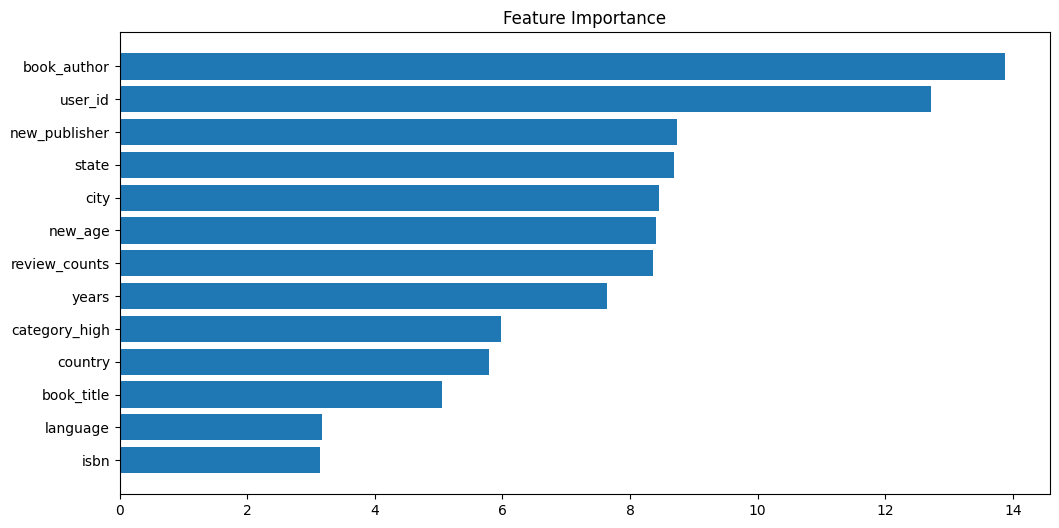

In [248]:
feature_importance = cat_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [254]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                     pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,7.210964
1,116866,0002005018,7.386553
2,152827,0060973129,7.709905
3,157969,0374157065,7.692078
4,67958,0399135782,7.755114
...,...,...,...
76694,278543,1576734218,6.168773
76695,278563,3492223710,6.444625
76696,278633,1896095186,6.595519
76697,278668,8408044079,5.130847


In [255]:
submit.to_csv('/home/code/submit/CB_HPO_Pred_drop_all_feats_segmentation_age_jun.csv', index = False)

In [52]:
'''
submit['rating'] = submit['rating'].round().astype(int)
submit.to_csv('/home/code/submit/CB_HPO_Pred_AVG_round.csv', index = False)
'''

- best_params = {'learning_rate': 0.1, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    - LB : 2.2369 / CV : 1.7941

- best_params = {'learning_rate': 0.1, 'reg_lambda': 10, 'random_strength': 26, 'depth': 9, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3741523922560336}
    - LB : 2.2479 / CV : 1.7941

- best_params = {'depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'random_strength': 0.001, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.739458755076581} 
    - LB : 2.2444 / CV : 1.78230

- best_params = {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    - LB : / CV : 1.76569 

## LightGBM

In [14]:
def objectiveLGBM(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'boosting_type' : trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves' : trial.suggest_int('num_leaves', 30, 50),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.1, 0.5]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.3, 0.5, 0.7, 1.0]),
        'subsample' : trial.suggest_categorical('subsample', [0.1, 0.3, 0.5, 0.7, 1.0]),
        'reg_alpha' : trial.suggest_categorical('reg_alpha', [1e-3, 0.1, 1, 5, 10]),
        'reg_lambda' : trial.suggest_categorical('reg_lambda', [1e-3, 0.1, 1, 5, 10]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1e-3, 0.1, 1, 5, 10]),
    }
    lgbm_model = LGBMRegressor(**param, n_estimators = 5000, objective = 'regression', metric = 'rmse',
                               n_jobs = -1, verbose = -1, random_state = SEED)
    callback = lightgbm.early_stopping(stopping_rounds = 100)
    lgbm_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                   eval_metric = 'rmse', callbacks = [callback])
    
    score = mean_squared_error(y_valid, lgbm_model.predict(X_valid), squared = False)
    return score

In [15]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveLGBM(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n') 

[I 2023-12-15 13:08:07,509] A new study created in memory with name: no-name-2b5465e9-b405-46d5-8a39-a72bff979798
[I 2023-12-15 13:13:22,558] Trial 0 finished with value: 1.9462932670262931 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.5, 'colsample_bytree': 0.7, 'subsample': 1.0, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:23:04,161] Trial 1 finished with value: 2.7512655857240094 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 0.5, 'subsample': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'min_child_weight': 0.1}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:27:42,611] Trial 2 finished with value: 7.630890264743444 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 15, 'learning_rate': 0.5, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 10, '

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.12043	valid_1's rmse: 2.1288


[I 2023-12-15 13:28:02,097] Trial 3 finished with value: 2.1288043693622063 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 0.1, 'subsample': 0.1, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:31:12,186] Trial 4 finished with value: 7.395880250694369 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'max_depth': 5, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.3, 'reg_alpha': 10, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 0 with value: 1.9462932670262931.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.89957	valid_1's rmse: 1.9121


[I 2023-12-15 13:31:24,501] Trial 5 finished with value: 1.912103023622258 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 1, 'learning_rate': 0.001, 'colsample_bytree': 0.7, 'subsample': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10, 'min_child_weight': 10}. Best is trial 5 with value: 1.912103023622258.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.91529	valid_1's rmse: 1.92689


[I 2023-12-15 13:31:37,414] Trial 6 finished with value: 1.9268898092436648 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 2, 'learning_rate': 0.001, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 5, 'reg_lambda': 0.001, 'min_child_weight': 0.001}. Best is trial 5 with value: 1.912103023622258.
[I 2023-12-15 13:37:40,556] Trial 7 finished with value: 7.040715559633694 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 3, 'learning_rate': 1e-05, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 5 with value: 1.912103023622258.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:37:41,548] Trial 8 finished with value: 1.8746150189688395 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.5, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 0.001}. Best is trial 8 with value: 1.8746150189688395.


Early stopping, best iteration is:
[60]	training's rmse: 1.82236	valid_1's rmse: 1.87462


[I 2023-12-15 13:39:44,804] Trial 9 finished with value: 7.143864739495544 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 1, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 8 with value: 1.8746150189688395.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.77405	valid_1's rmse: 1.85849


[I 2023-12-15 13:39:48,696] Trial 10 finished with value: 1.8584892610762904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 10 with value: 1.8584892610762904.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.77405	valid_1's rmse: 1.85849


[I 2023-12-15 13:39:52,377] Trial 11 finished with value: 1.8584892610762904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 10 with value: 1.8584892610762904.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:39:55,595] Trial 12 finished with value: 1.857775242096866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[552]	training's rmse: 1.7623	valid_1's rmse: 1.85778
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:39:58,378] Trial 13 finished with value: 1.8585193975128478 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[425]	training's rmse: 1.77931	valid_1's rmse: 1.85852
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:01,583] Trial 14 finished with value: 1.857775242096866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[552]	training's rmse: 1.7623	valid_1's rmse: 1.85778
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:04,694] Trial 15 finished with value: 1.8589018676501479 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[528]	training's rmse: 1.7728	valid_1's rmse: 1.8589
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:07,616] Trial 16 finished with value: 1.8577964842982615 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[423]	training's rmse: 1.77454	valid_1's rmse: 1.8578
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.38464	valid_1's rmse: 2.38748


[I 2023-12-15 13:40:54,741] Trial 17 finished with value: 2.387477835090298 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 10, 'learning_rate': 1e-05, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001, 'min_child_weight': 0.1}. Best is trial 12 with value: 1.857775242096866.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:57,363] Trial 18 finished with value: 1.8587716897589244 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[377]	training's rmse: 1.7925	valid_1's rmse: 1.85877
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:01,099] Trial 19 finished with value: 1.8582821669272167 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[573]	training's rmse: 1.76466	valid_1's rmse: 1.85828
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:04,206] Trial 20 finished with value: 1.8588447516713684 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[539]	training's rmse: 1.78037	valid_1's rmse: 1.85884
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:07,260] Trial 21 finished with value: 1.8587113110373277 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[518]	training's rmse: 1.76278	valid_1's rmse: 1.85871
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:11,075] Trial 22 finished with value: 1.8575745931789833 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[650]	training's rmse: 1.73984	valid_1's rmse: 1.85757
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:14,329] Trial 23 finished with value: 1.85818538329485 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[522]	training's rmse: 1.75685	valid_1's rmse: 1.85819
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.38463	valid_1's rmse: 2.38747


[I 2023-12-15 13:42:01,821] Trial 24 finished with value: 2.3874743996148307 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 13, 'learning_rate': 1e-05, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:04,560] Trial 25 finished with value: 1.8585842402412496 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.1, 'reg_alpha': 5, 'reg_lambda': 0.001, 'min_child_weight': 10}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[409]	training's rmse: 1.78549	valid_1's rmse: 1.85858
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:08,033] Trial 26 finished with value: 1.8584412191840736 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 0.1}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[524]	training's rmse: 1.75144	valid_1's rmse: 1.85844
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:10,480] Trial 27 finished with value: 1.8600474860038052 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[350]	training's rmse: 1.78709	valid_1's rmse: 1.86005
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:14,359] Trial 28 finished with value: 1.8574871315861985 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[736]	training's rmse: 1.76218	valid_1's rmse: 1.85749


[I 2023-12-15 13:52:56,996] Trial 29 finished with value: 7.039681670015834 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'max_depth': 10, 'learning_rate': 1e-05, 'colsample_bytree': 0.7, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:00,438] Trial 30 finished with value: 1.8585056496616352 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[577]	training's rmse: 1.77664	valid_1's rmse: 1.85851
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:03,316] Trial 31 finished with value: 1.8587658341672764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[460]	training's rmse: 1.78252	valid_1's rmse: 1.85877
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:06,052] Trial 32 finished with value: 1.8582679416830166 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[474]	training's rmse: 1.78822	valid_1's rmse: 1.85827
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:09,461] Trial 33 finished with value: 1.8582230064307186 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 0.1}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[505]	training's rmse: 1.76928	valid_1's rmse: 1.85822


[I 2023-12-15 14:04:53,433] Trial 34 finished with value: 2.6918320047613067 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 1.0, 'subsample': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[755]	training's rmse: 1.8458	valid_1's rmse: 1.8692


[I 2023-12-15 14:04:57,793] Trial 35 finished with value: 1.869200286893409 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.1, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.
[I 2023-12-15 14:09:39,168] Trial 36 finished with value: 6.48642594539177 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'max_depth': 14, 'learning_rate': 0.5, 'colsample_bytree': 0.5, 'subsample': 0.1, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 1}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.84985	valid_1's rmse: 1.87116


[I 2023-12-15 14:10:17,376] Trial 37 finished with value: 1.871155010870594 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 7, 'learning_rate': 0.001, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'min_child_weight': 10}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[786]	training's rmse: 1.75786	valid_1's rmse: 1.85858


[I 2023-12-15 14:10:21,593] Trial 38 finished with value: 1.858578974238592 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.
[I 2023-12-15 14:19:13,978] Trial 39 finished with value: 5.036427020323276 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.86132	valid_1's rmse: 1.8763


[I 2023-12-15 14:19:38,249] Trial 40 finished with value: 1.8763005927508853 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 4, 'learning_rate': 0.001, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:42,482] Trial 41 finished with value: 1.857660253962212 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[697]	training's rmse: 1.73274	valid_1's rmse: 1.85766
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:47,268] Trial 42 finished with value: 1.8570557359879565 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 42 with value: 1.8570557359879565.


Early stopping, best iteration is:
[728]	training's rmse: 1.72591	valid_1's rmse: 1.85706
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:50,756] Trial 43 finished with value: 1.8584288407622231 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 42 with value: 1.8570557359879565.


Early stopping, best iteration is:
[527]	training's rmse: 1.7551	valid_1's rmse: 1.85843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	training's rmse: 1.76437	valid_1's rmse: 1.85693


[I 2023-12-15 14:19:54,867] Trial 44 finished with value: 1.8569333368094627 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	training's rmse: 1.76437	valid_1's rmse: 1.85693


[I 2023-12-15 14:19:59,063] Trial 45 finished with value: 1.8569333368094627 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.41605	valid_1's rmse: 2.41838


[I 2023-12-15 14:20:34,207] Trial 46 finished with value: 2.418384658168914 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 1e-05, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	training's rmse: 1.77565	valid_1's rmse: 1.85765


[I 2023-12-15 14:20:37,907] Trial 47 finished with value: 1.8576454680744567 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.
[I 2023-12-15 14:25:54,759] Trial 48 finished with value: 6.307307968382457 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 10, 'learning_rate': 0.5, 'colsample_bytree': 0.3, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:25:58,069] Trial 49 finished with value: 1.8577011339968028 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Early stopping, best iteration is:
[517]	training's rmse: 1.78368	valid_1's rmse: 1.8577
Best trial : score 1.8569333368094627, 
 params = {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1} 



In [16]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_GB['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params # lgbm_best_params
    
    lgbm_reg = LGBMRegressor(**param, n_estimators = 5000, objective = 'regression', metric = 'rmse',
                             n_jobs = -1, verbose = -1, random_state = SEED)
    callback = lightgbm.early_stopping(stopping_rounds = 100)
    lgbm_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                   eval_metric = 'rmse', callbacks = [callback])
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, lgbm_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')

    # Predict
    pred = lgbm_reg.predict(test_GB.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred

print(f'LGBM RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[669]	training's rmse: 1.77124	valid_1's rmse: 1.84505
Valid Set 1 번째 Fold RMSE : 1.84505


 10%|█         | 1/10 [00:04<00:39,  4.36s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	training's rmse: 1.76938	valid_1's rmse: 1.84211
Valid Set 2 번째 Fold RMSE : 1.84211


 20%|██        | 2/10 [00:08<00:35,  4.46s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[750]	training's rmse: 1.76591	valid_1's rmse: 1.83455
Valid Set 3 번째 Fold RMSE : 1.83455


 30%|███       | 3/10 [00:13<00:32,  4.58s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.76602	valid_1's rmse: 1.84613
Valid Set 4 번째 Fold RMSE : 1.84613


 40%|████      | 4/10 [00:17<00:26,  4.46s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[955]	training's rmse: 1.74373	valid_1's rmse: 1.84995
Valid Set 5 번째 Fold RMSE : 1.84995


 50%|█████     | 5/10 [00:23<00:24,  4.96s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[919]	training's rmse: 1.74868	valid_1's rmse: 1.85163
Valid Set 6 번째 Fold RMSE : 1.85163


 60%|██████    | 6/10 [00:29<00:20,  5.22s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[691]	training's rmse: 1.76928	valid_1's rmse: 1.84911
Valid Set 7 번째 Fold RMSE : 1.84911


 70%|███████   | 7/10 [00:33<00:14,  4.92s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[877]	training's rmse: 1.75255	valid_1's rmse: 1.85598
Valid Set 8 번째 Fold RMSE : 1.85598


 80%|████████  | 8/10 [00:39<00:10,  5.08s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[813]	training's rmse: 1.76037	valid_1's rmse: 1.84043
Valid Set 9 번째 Fold RMSE : 1.84043


 90%|█████████ | 9/10 [00:44<00:05,  5.06s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	training's rmse: 1.77385	valid_1's rmse: 1.85223
Valid Set 10 번째 Fold RMSE : 1.85223


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]

LGBM RMSE 평균 : 1.84672 



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

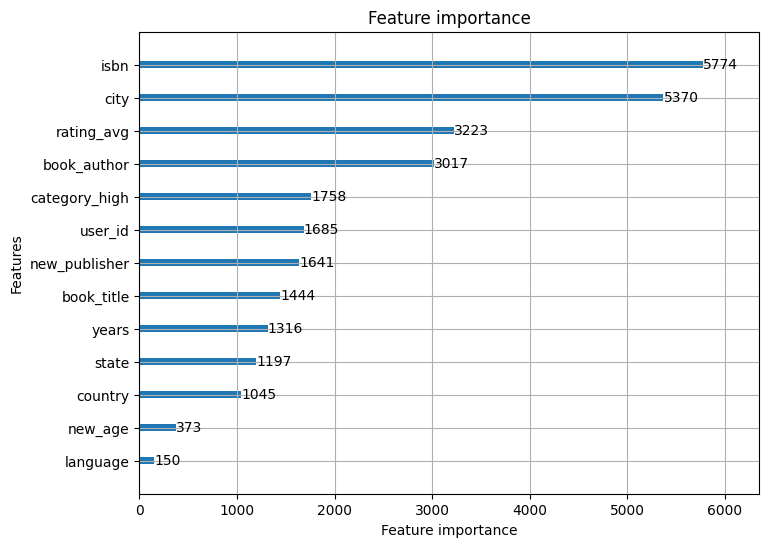

In [17]:
# Feature Importance
fig, ax = plt.subplots(figsize = (8, 6))
lgbm_plot_importance(lgbm_reg, ax = ax)

In [18]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                          pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,6.949023
1,116866,0002005018,7.718842
2,152827,0060973129,8.618080
3,157969,0374157065,7.926602
4,67958,0399135782,8.120157
...,...,...,...
76694,278543,1576734218,6.351776
76695,278563,3492223710,7.332121
76696,278633,1896095186,7.038254
76697,278668,8408044079,3.432230


In [19]:
submit.to_csv('/home/code/submit/LGBM_HPO_Pred_AVG.csv', index = False)

In [20]:
'''
submit['rating'] = submit['rating'].round().astype(int)
submit.to_csv('/home/code/submit/LGBM_HPO_Pred_AVG_round.csv', index = False)
'''

- {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 3, 'learning_rate': 0.5, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 1}
    - LB : 2.2771 / CV : 1.85789

## XGBoost

In [18]:
def objectiveXGB(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'booster' : trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.05, 0.1, 0.5]), # 1e-5,
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.5, 1]),
        'lambda' : trial.suggest_categorical('lambda', [1e-5, 1e-3, 1, 5, 10]),
        'alpha' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'max_delta_step' : trial.suggest_categorical('max_delta_step', [0.1, 0.5, 1, 5, 10]),
    }
    
    # XGBRegressor 사용
    model = XGBRegressor(**param, n_estimators = 5000, objective = 'reg:squarederror', eval_metric = 'rmse',
                         nthread = -1, gpu_id = 0, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                         early_stopping_rounds = 100, random_state = SEED)
    xgb_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 300)
    
    # Valid Set RMSE 계산
    score = mean_squared_error(y_valid, xgb_model.predict(X_valid), squared = False)
    return score

In [19]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveXGB(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2023-12-16 02:39:55,880] A new study created in memory with name: no-name-2467daf9-4961-47e2-a2f4-d566c45aeef2


[0]	validation_0-rmse:2.00523	validation_1-rmse:2.03346
[105]	validation_0-rmse:1.38723	validation_1-rmse:1.95045


[I 2023-12-16 02:40:02,689] Trial 0 finished with value: 1.887207962657868 and parameters: {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.5, 'min_child_weight': 7, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 1.0, 'max_delta_step': 10}. Best is trial 0 with value: 1.887207962657868.


[0]	validation_0-rmse:2.43202	validation_1-rmse:2.43406
[300]	validation_0-rmse:2.40486	validation_1-rmse:2.40755
[600]	validation_0-rmse:2.37566	validation_1-rmse:2.37906
[900]	validation_0-rmse:2.34489	validation_1-rmse:2.34903
[1200]	validation_0-rmse:2.31603	validation_1-rmse:2.32088
[1500]	validation_0-rmse:2.29553	validation_1-rmse:2.30102
[1800]	validation_0-rmse:2.27405	validation_1-rmse:2.28017
[2100]	validation_0-rmse:2.24965	validation_1-rmse:2.25647
[2400]	validation_0-rmse:2.23270	validation_1-rmse:2.24004
[2700]	validation_0-rmse:2.21629	validation_1-rmse:2.22413
[3000]	validation_0-rmse:2.20240	validation_1-rmse:2.21075
[3300]	validation_0-rmse:2.18910	validation_1-rmse:2.19790
[3600]	validation_0-rmse:2.17755	validation_1-rmse:2.18678
[3900]	validation_0-rmse:2.16438	validation_1-rmse:2.17405
[4200]	validation_0-rmse:2.15394	validation_1-rmse:2.16399
[4500]	validation_0-rmse:2.13821	validation_1-rmse:2.14877
[4800]	validation_0-rmse:2.12192	validation_1-rmse:2.13298
[49

[I 2023-12-16 02:40:29,997] Trial 1 finished with value: 2.1257598934600197 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.001, 'min_child_weight': 5, 'alpha': 5, 'colsample_bytree': 0.1, 'lambda': 1, 'subsample': 0.8, 'max_delta_step': 5}. Best is trial 0 with value: 1.887207962657868.


[0]	validation_0-rmse:2.40945	validation_1-rmse:2.41180
[300]	validation_0-rmse:2.02143	validation_1-rmse:2.03950
[600]	validation_0-rmse:1.88665	validation_1-rmse:1.90704
[900]	validation_0-rmse:1.85113	validation_1-rmse:1.87454
[1200]	validation_0-rmse:1.84652	validation_1-rmse:1.87085
[1322]	validation_0-rmse:1.84637	validation_1-rmse:1.87082


[I 2023-12-16 02:40:34,130] Trial 2 finished with value: 1.8705904401754743 and parameters: {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 0.1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.1}. Best is trial 2 with value: 1.8705904401754743.


[0]	validation_0-rmse:2.43257	validation_1-rmse:2.43460
[300]	validation_0-rmse:2.41860	validation_1-rmse:2.42100
[600]	validation_0-rmse:2.40350	validation_1-rmse:2.40629
[900]	validation_0-rmse:2.38703	validation_1-rmse:2.39023
[1200]	validation_0-rmse:2.37125	validation_1-rmse:2.37483
[1500]	validation_0-rmse:2.35926	validation_1-rmse:2.36321
[1800]	validation_0-rmse:2.34674	validation_1-rmse:2.35102
[2100]	validation_0-rmse:2.33232	validation_1-rmse:2.33697
[2400]	validation_0-rmse:2.32172	validation_1-rmse:2.32665


In [ ]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_GB['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params # xgb_best_params
    
    # Best Parameter 학습
    xgb_reg = XGBRegressor(**param, n_estimators = 5000, objective = 'reg:squarederror', eval_metric = 'rmse', 
                           nthread = -1, gpu_id = 0, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                           early_stopping_rounds = 100, random_state = SEED)
    xgb_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, xgb_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = xgb_reg.predict(test_GB.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred

print(f'XGBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

 10%|█         | 1/10 [07:27<1:07:10, 447.87s/it]

Valid Set 1 번째 Fold RMSE : 1.85683


 20%|██        | 2/10 [14:43<58:46, 440.80s/it]  

Valid Set 2 번째 Fold RMSE : 1.85320


 30%|███       | 3/10 [22:06<51:30, 441.50s/it]

Valid Set 3 번째 Fold RMSE : 1.84803


 40%|████      | 4/10 [29:07<43:22, 433.73s/it]

Valid Set 4 번째 Fold RMSE : 1.85734


 50%|█████     | 5/10 [36:33<36:29, 437.86s/it]

Valid Set 5 번째 Fold RMSE : 1.86337


 60%|██████    | 6/10 [43:45<29:04, 436.14s/it]

Valid Set 6 번째 Fold RMSE : 1.86145


 70%|███████   | 7/10 [50:33<21:20, 426.67s/it]

Valid Set 7 번째 Fold RMSE : 1.86348


 80%|████████  | 8/10 [57:53<14:22, 431.13s/it]

Valid Set 8 번째 Fold RMSE : 1.86570


 90%|█████████ | 9/10 [1:05:10<07:12, 432.80s/it]

Valid Set 9 번째 Fold RMSE : 1.85662


100%|██████████| 10/10 [1:12:25<00:00, 434.53s/it]

Valid Set 10 번째 Fold RMSE : 1.86556
XGBoost RMSE 평균 : 1.85916 



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

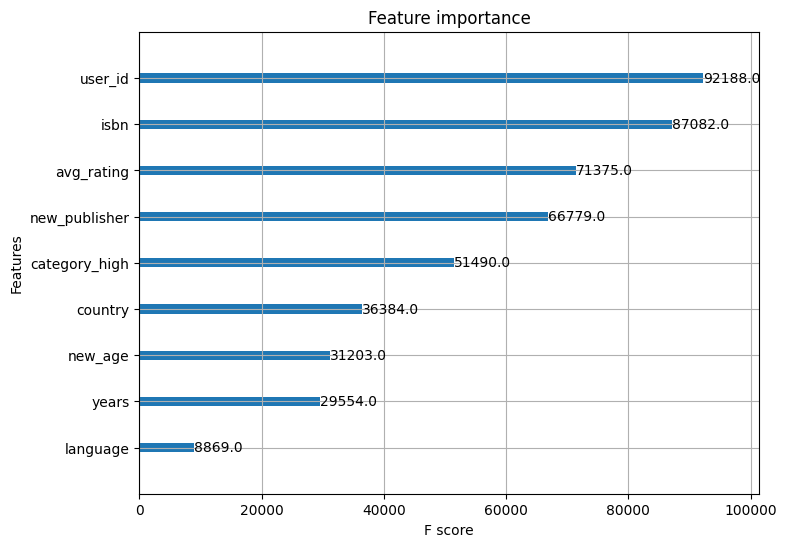

In [ ]:
# Feature Importance
fig, ax = plt.subplots(figsize = (8, 6))
xgb_plot_importance(xgb_reg, ax = ax)

In [ ]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                          pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,7.066980
1,116866,0002005018,7.668482
2,152827,0060973129,8.320372
3,157969,0374157065,7.769433
4,67958,0399135782,8.436759
...,...,...,...
76694,278543,1576734218,6.505219
76695,278563,3492223710,6.650600
76696,278633,1896095186,6.597798
76697,278668,8408044079,2.813656


In [ ]:
submit.to_csv('/home/code/submit/XGB_HPO_Pred_AVG.csv', index = False)

In [ ]:
'''
submit['rating'] = submit['rating'].round().astype(int)
submit.to_csv('/home/code/submit/XGB_HPO_Pred_AVG_round.csv', index = False)
'''

# Ensemble

In [51]:
os.listdir('/home/code/submit/')

['20231214_141423_DeepCoNN.csv',
 'Catboost_Optuna_withGPU_fold10.csv',
 '20231215_031836_DCN.csv',
 '20231212_225413_FM.csv',
 'Catboost_Optuna_fold10_loc_round.csv',
 'XGBoost_Optuna_withGPU_fold10.csv',
 '20231215_080141_DCN.csv',
 '20231215_075938_DCN.csv',
 'LGBM_Optuna_withGPU_fold10.csv',
 'Catboost_Optuna_withGPU.csv',
 'Catboost_Optuna.csv',
 'Catboost_Optuna_fold10_loc.csv',
 '20231215_082021_DCN.csv',
 '20231215_062520_DCN.csv']